# Entrance and departure behavior

This notebook investigates the entrance and departure behavior, and its timing, among different user groups.

- non-tourists
- tourists


In [4]:
import datetime
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd


IMSI = 'imsi'
MCC ='mcc'
DATE = 'date'

ENTRANCES = 'entrances'
DEPARTURES = 'departures'

date_fmt = '%Y-%m-%d'

DATA_FILEPATH = '../data/private/'
metrics_filepath = '../outputs/metrics/'

In [5]:
PRESENCE_TOURISTS_FPATH = DATA_FILEPATH+'presence/2020/presence_tourists.csv'
PRESENCE_OTHERS_FPATH = DATA_FILEPATH+'presence/2020/presence_others.csv'
ENTRANCE_DEPARTURE_FPATH = metrics_filepath+'2020/entrance_departure.csv'

In [3]:
entrances_departures_df = pd.read_csv(ENTRANCE_DEPARTURE_FPATH).rename(
    columns={'Unnamed: 0': DATE}).set_index(DATE)
entrances_departures_df.head()

,entrance_Andorran,entrance_Spanish,entrance_French,entrance_British,entrance_Other,departures_Andorran,departures_Spanish,departures_French,departures_British,departures_Other
date,,,,,,,,,,
2020-01-01,0,0,0,0,0,255,9104,3114,400,2134
2020-01-02,0,0,0,0,0,353,11011,7293,574,2959
2020-01-03,0,0,0,0,0,365,11053,5471,678,3003
2020-01-04,0,0,0,0,0,348,13816,5148,954,3316
2020-01-05,0,0,0,0,0,421,12818,3776,664,2577


In [ ]:
t_presence_df = pd.read_csv(PRESENCE_TOURISTS_FPATH).rename(
    columns={'Unnamed: 0': IMSI}).set_index(IMSI)
# t_presence_df.head()

In [ ]:
o_presence_df = pd.read_csv(PRESENCE_OTHERS_FPATH).rename(
    columns={'Unnamed: 0': IMSI}).set_index(IMSI)
# o_presence_df.head()

In [99]:
datetimes = pd.to_datetime(o_presence_df.columns)

In [7]:
def get_imsi_entrances_departures_map(df):
    imsis = df.index
    imsis_map = {}
    for i, imsi in enumerate(imsis):
        if i%50000==0:
            print('%s/%s'% (i, len(imsis)))
        days = df.loc[imsi]
        entrances = []
        departures = []
        day_before = days[0]
        for i_d, day in enumerate(days[1:]):
            i_d = i_d + 1
            if (not day_before) and day:
                entrances += [i_d]
            elif day_before and (not day):
                departures += [i_d - 1]
            day_before = day
        imsis_map[imsi] = {ENTRANCES: entrances, DEPARTURES: departures}
    return imsis_map

In [8]:
o_imsis_map = get_imsi_entrances_departures_map(o_presence_df)

0/73382
50000/73382


In [9]:
t_imsis_map = get_imsi_entrances_departures_map(t_presence_df)

0/1215417
50000/1215417
100000/1215417
150000/1215417
200000/1215417
250000/1215417
300000/1215417
350000/1215417
400000/1215417
450000/1215417
500000/1215417
550000/1215417
600000/1215417
650000/1215417
700000/1215417
750000/1215417
800000/1215417
850000/1215417
900000/1215417
950000/1215417
1000000/1215417
1050000/1215417
1100000/1215417
1150000/1215417
1200000/1215417


Plot out the departure and entrance timing for the following groups:

Tourists

Others
- all others

vs

- others no return set: Set of Others limited to those who left and didn't return
- others delayed return set: Set of Others who left and did  return  after more than  D=30 days
    (Are these the temp workers returning for work?)


In [10]:
def has_delayed_return(entrances, departures, delay=30):
    """Returns true if there is a departure followed by an entrance > delay days later."""
    if (len(entrances)==0) or (len(departures)==0):
        return False
    i_first_reentry = 0 if entrances[0] > departures[0] else 1
    i_departure = 0
    for i_reentry in range(i_first_reentry, len(entrances)):
        if entrances[i_reentry] > (departures[i_departure]+delay):
            return True
        i_departure += 1
    return False
    

def is_no_return(entrances, departures):
    """Returns true if 1 departure and last entrance is before departure."""
    return (len(departures) == 1) and ((len(entrances)==0) or (entrances[-1] < departures[0]))
    

In [11]:
o_imsis_no_return = {imsi for imsi, e_d in o_imsis_map.items() if is_no_return(e_d[ENTRANCES], e_d[DEPARTURES])}
o_delayed_return = {imsi for imsi, e_d in o_imsis_map.items() if has_delayed_return(e_d[ENTRANCES], e_d[DEPARTURES])}
print(len(o_imsis_no_return))
print(len(o_delayed_return))
print(len(o_imsis_map))

8078
18664
73382


In [12]:
columns = ['tourists', 'others', '(others) no return', '(others) delayed return']

entrance_df=pd.DataFrame(index=datetimes, columns=columns)
entrance_df.loc[:,:]=0
departure_df=pd.DataFrame(index=datetimes, columns=columns)
departure_df.loc[:,:]=0

for i,(imsi, imsi_map) in enumerate(o_imsis_map.items()):
    if (i%50000==0):
        print('%s/%s'% (i, len(o_imsis_map)))
    entrances = imsi_map[ENTRANCES]
    departures = imsi_map[DEPARTURES]
    # update the the total entrances and exits
    for ind_day in entrances:
        entrance_df.loc[datetimes[ind_day], 'others']+=1
        if imsi in o_delayed_return:
            entrance_df.loc[datetimes[ind_day], '(others) delayed return']+=1
        if imsi in o_imsis_no_return:
            entrance_df.loc[datetimes[ind_day], '(others) no return']+=1
            
    for ind_day in departures:
        departure_df.loc[datetimes[ind_day], 'others']+=1 
        if imsi in o_delayed_return:
            departure_df.loc[datetimes[ind_day], '(others) delayed return']+=1 
        if imsi in o_imsis_no_return:
            departure_df.loc[datetimes[ind_day], '(others) no return']+=1  

for i,(imsi, imsi_map) in enumerate(t_imsis_map.items()):
    if (i%50000==0):
        print('%s/%s'% (i, len(t_imsis_map)))
    entrances = imsi_map[ENTRANCES]
    departures = imsi_map[DEPARTURES]
    # update the the total entrances and exits
    for ind_day in entrances:
        entrance_df.loc[datetimes[ind_day], 'tourists']+=1
    for ind_day in departures:
        departure_df.loc[datetimes[ind_day], 'tourists']+=1    
        

entrance_df.sort_values('others', ascending=False).head()

0/73382
50000/73382
0/1215417
50000/1215417
100000/1215417
150000/1215417
200000/1215417
250000/1215417
300000/1215417
350000/1215417
400000/1215417
450000/1215417
500000/1215417
550000/1215417
600000/1215417
650000/1215417
700000/1215417
750000/1215417
800000/1215417
850000/1215417
900000/1215417
950000/1215417
1000000/1215417
1050000/1215417
1100000/1215417
1150000/1215417
1200000/1215417


,tourists,others,(others) no return,(others) delayed return
2020-08-23,8368,1200,0,322
2020-08-24,9288,1159,0,422
2020-08-31,4681,1070,0,476
2020-03-02,23431,1049,126,606
2020-08-30,6169,936,0,323


In [13]:
departure_df.head()

,tourists,others,(others) no return,(others) delayed return
2020-01-01,14897,110,0,79
2020-01-02,22049,141,0,114
2020-01-03,20382,188,0,148
2020-01-04,23387,195,0,154
2020-01-05,20024,232,0,199


In [14]:
# set the entrances for missing data to NaN
missing_dates = [
datetime.datetime(2020, 2, 14, 0, 0),
datetime.datetime(2020, 2, 15, 0, 0),
datetime.datetime(2020, 2, 16, 0, 0),
datetime.datetime(2020, 2, 17, 0, 0),
datetime.datetime(2020, 2, 18, 0, 0),
datetime.datetime(2020, 2, 19, 0, 0),
datetime.datetime(2020, 2, 20, 0, 0),
datetime.datetime(2020, 2, 21, 0, 0),
datetime.datetime(2020, 2, 22, 0, 0),
datetime.datetime(2020, 2, 23, 0, 0),
datetime.datetime(2020, 2, 24, 0, 0),
datetime.datetime(2020, 2, 25, 0, 0),
datetime.datetime(2020, 2, 26, 0, 0),
datetime.datetime(2020, 2, 27, 0, 0),
datetime.datetime(2020, 2, 28, 0, 0),
datetime.datetime(2020, 2, 29, 0, 0),
datetime.datetime(2020, 3, 1, 0, 0),
datetime.datetime(2020, 6, 28, 0, 0),
datetime.datetime(2020, 6, 29, 0, 0),
datetime.datetime(2020, 7, 21, 0, 0),
datetime.datetime(2020, 7, 22, 0, 0),
datetime.datetime(2020, 7, 23, 0, 0),
datetime.datetime(2020, 7, 24, 0, 0),
datetime.datetime(2020, 7, 25, 0, 0),
datetime.datetime(2020, 7, 26, 0, 0),
datetime.datetime(2020, 7, 27, 0, 0),
datetime.datetime(2020, 10, 1, 0, 0),
datetime.datetime(2020, 10, 2, 0, 0),
datetime.datetime(2020, 10, 3, 0, 0),
datetime.datetime(2020, 10, 4, 0, 0),
datetime.datetime(2020, 10, 5, 0, 0),
datetime.datetime(2020, 10, 6, 0, 0)]

In [15]:
entrance_df.loc[missing_dates,:] = np.NaN
departure_df.loc[missing_dates,:] = np.NaN
entrance_df.head()

,tourists,others,(others) no return,(others) delayed return
2020-01-01,0,0,0,0
2020-01-02,0,0,0,0
2020-01-03,0,0,0,0
2020-01-04,0,0,0,0
2020-01-05,0,0,0,0


In [21]:
entrance_df['all'] = entrance_df['tourists']+entrance_df['others']
departure_df['all'] = departure_df['tourists']+departure_df['others']
departure_df.head()

,tourists,others,(others) no return,(others) delayed return,all
2020-01-01,14897,110,0,79,15007
2020-01-02,22049,141,0,114,22190
2020-01-03,20382,188,0,148,20570
2020-01-04,23387,195,0,154,23582
2020-01-05,20024,232,0,199,20256


Make aggregated presence dataframe

```
date, tourists, non-tourists
```

In [38]:
assert((o_presence_df.columns == t_presence_df.columns).all())

In [39]:
t_present = []
o_present = []
for i, d in enumerate(o_presence_df.columns):
    t_present += [(t_presence_df[str(d)] > 0).sum()]
    o_present += [(o_presence_df[str(d)] > 0).sum()]
agg_presence_df = pd.DataFrame(data={
    DATE: pd.to_datetime(t_presence_df.columns),
    'tourists': t_present,
    'non-tourists': o_present,
}).set_index(DATE)
agg_presence_df.head()

,tourists,non-tourists
date,,
2020-01-01,205002,66110
2020-01-02,190105,66000
2020-01-03,168056,65859
2020-01-04,147674,65671
2020-01-05,124287,65476


# Plot them

In [67]:
agg_presence_df = agg_presence_df.reindex(datetimes)

Cut off the first and  last 2 weeks  from the plots to  account  for  window size

In [96]:
d1_str = (datetimes[0] + datetime.timedelta(days=14)).strftime(date_fmt)
d2_str = (datetimes[-1] + datetime.timedelta(days=-14)).strftime(date_fmt)
plot_index = agg_presence_df.loc[d1_str:d2_str].index
print('using plot index with index  from %s to %s' %  (plot_index[0], plot_index[-1]))

using plot index with index  from 2020-01-15 00:00:00 to 2020-10-17 00:00:00


In [123]:
# Tourists vs others

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')

entrances_color = 'tab:blue'
departures_color = 'tab:orange'

t_presence_color = 'tab:purple'
o_presence_color = 'tab:brown'

In [126]:
agg_presence_df[~agg_presence_df.index.isin(missing_dates)].head()

,tourists,non-tourists
2020-01-01,205002,66110
2020-01-02,190105,66000
2020-01-03,168056,65859
2020-01-04,147674,65671
2020-01-05,124287,65476


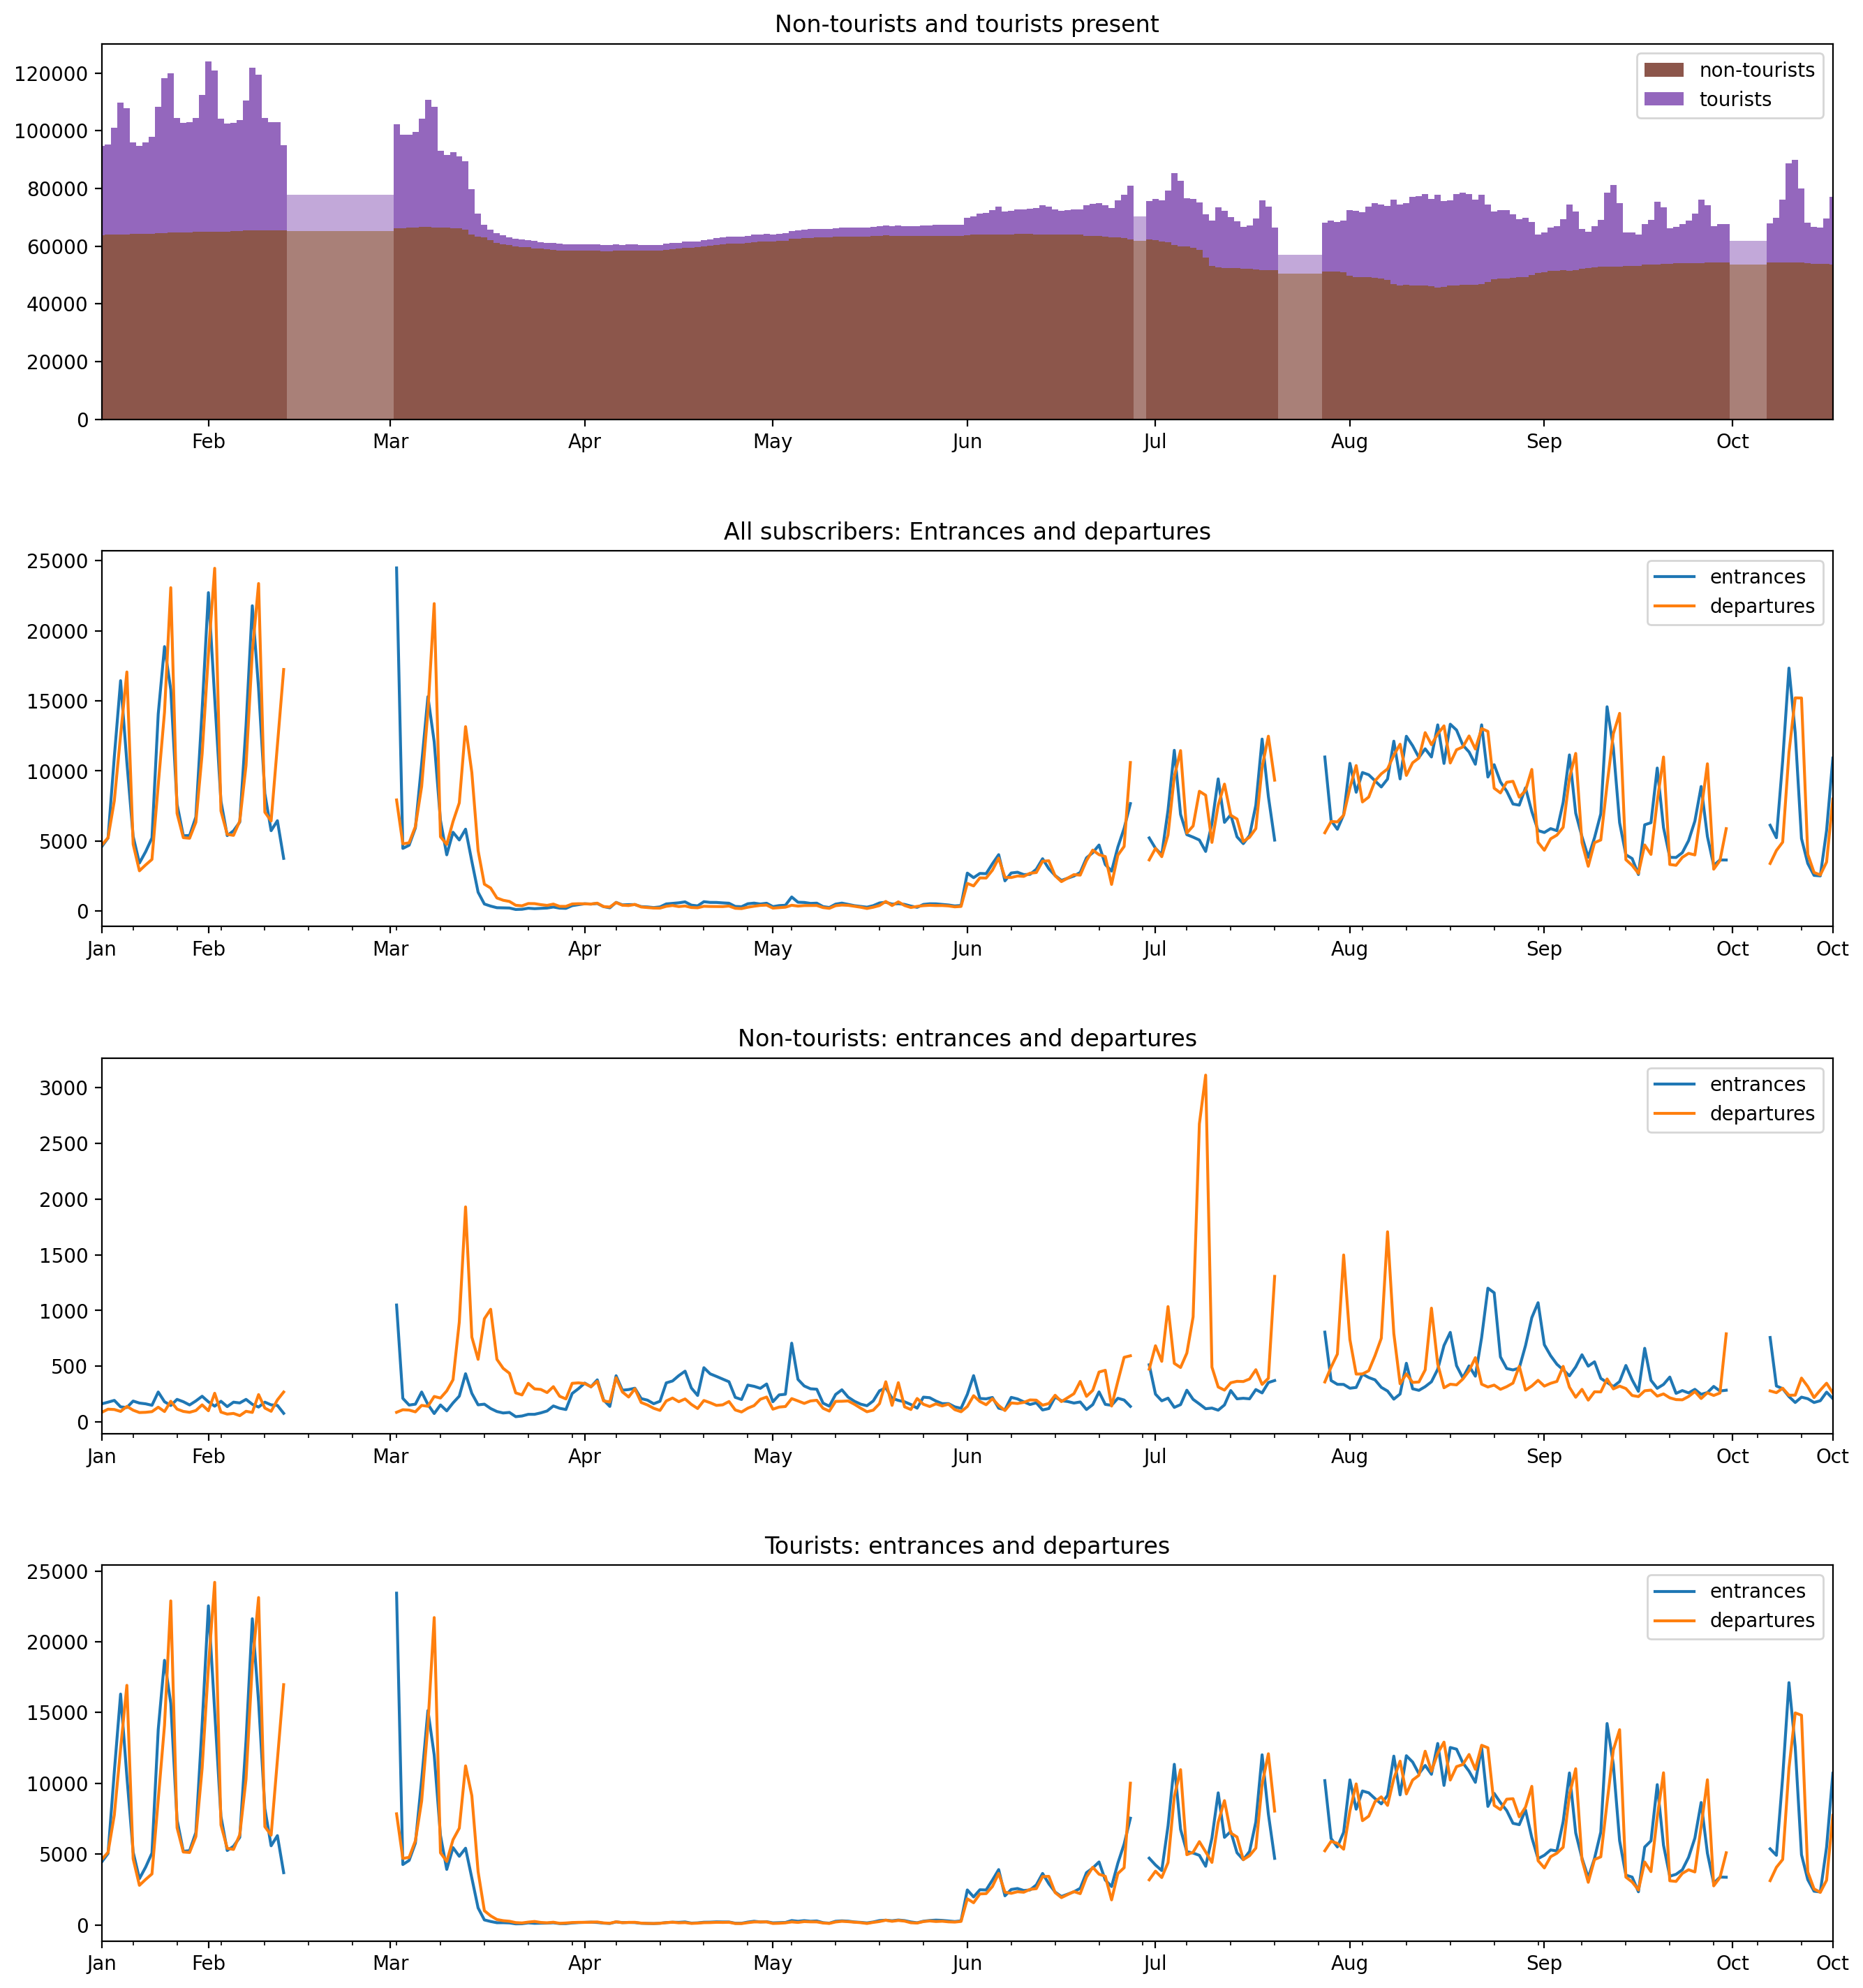

In [134]:
# Make the missing dates presence values lighter.

fig, axes = plt.subplots(4, figsize=(16, 18), dpi=100,)#sharex=True)
plt.subplots_adjust(hspace=0.35)

presence_ax = axes[0]
presence_ax.bar(plot_index,
    agg_presence_df[~agg_presence_df.index.isin(missing_dates)]['non-tourists'].reindex(plot_index), 
    1, 
    label='non-tourists',
    alpha=1,
    bottom=None,
    color=o_presence_color,
)
presence_ax.bar(plot_index,
    agg_presence_df[agg_presence_df.index.isin(missing_dates)]['non-tourists'].reindex(plot_index), 
    1,
    label='__nolegend__',
    alpha=0.75,
    bottom=None,
    color=o_presence_color,
)

presence_ax.bar(plot_index,
    agg_presence_df[~agg_presence_df.index.isin(missing_dates)]['tourists'].reindex(plot_index), 
    1, 
    label='tourists',
    alpha=1,
    bottom=agg_presence_df['non-tourists'].reindex(plot_index),
    color=t_presence_color,
)
presence_ax.bar(plot_index,
    agg_presence_df[agg_presence_df.index.isin(missing_dates)]['tourists'].reindex(plot_index), 
    1, 
    label='__nolegend__',
    alpha=0.57,
    bottom=agg_presence_df['non-tourists'].reindex(plot_index),
    color=t_presence_color,
)

presence_ax.set_title('Non-tourists and tourists present')

axes[1].set_title('All subscribers: Entrances and departures')
entrance_df['all'].reindex(plot_index).plot(
    legend=True, ax=axes[1], color=entrances_color, label='entrances')
departure_df['all'].reindex(plot_index).plot(
    legend=True, ax=axes[1], color=departures_color, label='departures')

axes[2].set_title('Non-tourists: entrances and departures')
entrance_df['others'].reindex(plot_index).plot(
    legend=True, ax=axes[2], color=entrances_color, label='entrances')
departure_df['others'].reindex(plot_index).plot(
    legend=True, ax=axes[2], color=departures_color, label='departures')

axes[3].set_title('Tourists: entrances and departures')
entrance_df['tourists'].reindex(plot_index).plot(
    legend=True, ax=axes[3], color=entrances_color, label='entrances')
departure_df['tourists'].reindex(plot_index).plot(
    legend=True, ax=axes[3], color=departures_color, label='departures')

for ax in axes:
    ax.xaxis.set_major_formatter(myFmt)
    ax.axes.set_xlim(plot_index[0], plot_index[-1])
    ax.legend()

Plot the difference between the classes of 'non-tourists'

<AxesSubplot:title={'center':'Entrances and exits by likely non-tourists who returned after a long delay'}>

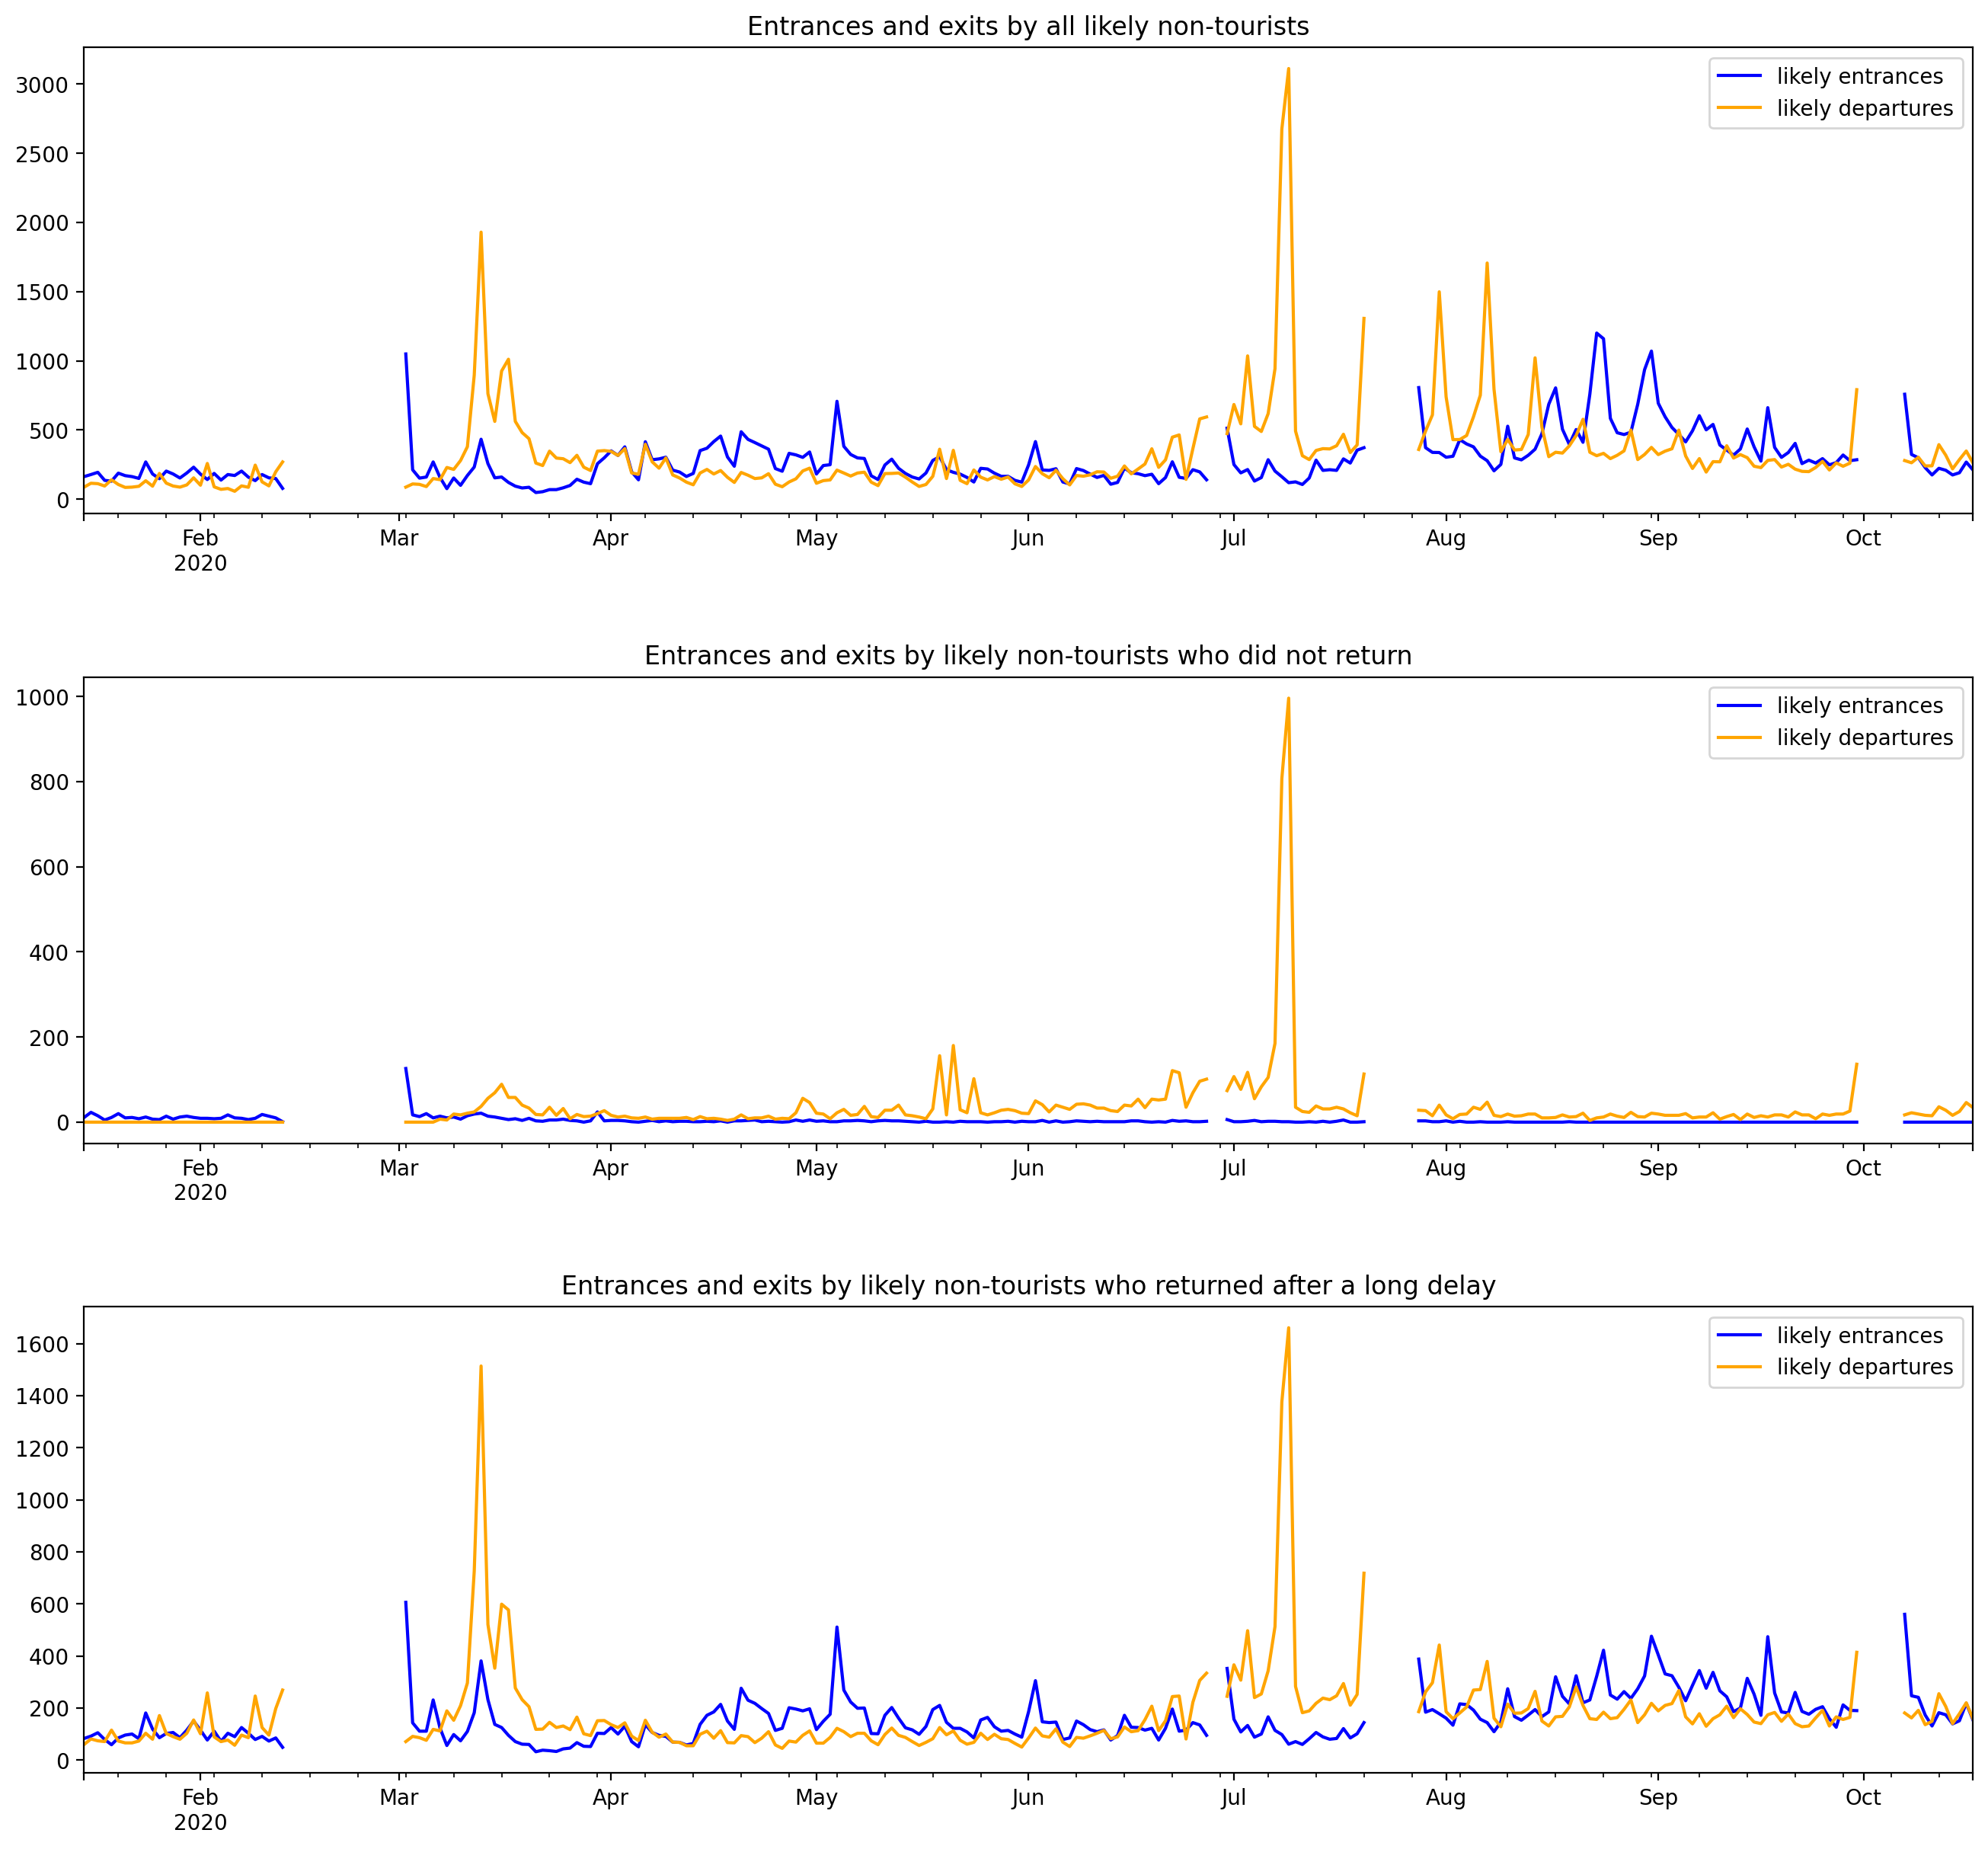

In [102]:
entrances_color = 'blue'
departures_color = 'orange'

fig, ax= plt.subplots(3, figsize=(16, 15), dpi=100,)#sharex=True)
plt.subplots_adjust(hspace=0.35)
ax[0].set_title('Entrances and exits by all likely non-tourists')
entrance_df['others'].reindex(plot_index).plot(
    legend=True, ax=ax[0], color=entrances_color, label='likely entrances')
departure_df['others'].reindex(plot_index).plot(
    legend=True, ax=ax[0], color=departures_color, label='likely departures')

ax[1].set_title('Entrances and exits by likely non-tourists who did not return')
entrance_df['(others) no return'].reindex(plot_index).plot(
    legend=True, ax=ax[1], color=entrances_color, label='likely entrances')
departure_df['(others) no return'].reindex(plot_index).plot(
    legend=True, ax=ax[1], color=departures_color, label='likely departures')

ax[2].set_title('Entrances and exits by likely non-tourists who returned after a long delay')
entrance_df['(others) delayed return'].reindex(plot_index).plot(
    legend=True, ax=ax[2], color=entrances_color, label='likely entrances')
departure_df['(others) delayed return'].reindex(plot_index).plot(
    legend=True, ax=ax[2], color=departures_color, label='likely departures')

When is the spike in departures by non-tourists?

In [34]:
departure_df['others'].loc['2020-07-01':'2020-7-14']

2020-07-01     684
2020-07-02     544
2020-07-03    1035
2020-07-04     526
2020-07-05     489
2020-07-06     618
2020-07-07     943
2020-07-08    2674
2020-07-09    3111
2020-07-10     492
2020-07-11     314
2020-07-12     286
2020-07-13     352
2020-07-14     365
Name: others, dtype: object

Dates and findings of interest:
- March 13-18: lockdown: 
    - Many non-tourists left right before each of these dates
    - Many likely non-touristts re-entered at this time. More of these people later returned.
      
- Late April and early May: Serology tests were  conducted  in May
    - No changes in (tourists entrances/departures, as to  be expected)
    - Many non-tourists returned in late April and early May, possibly to participate in serology tests
    - There was a spike in non-tourists who left and did not return at the end of May -- this may be temp workers who left after their serology tests.
    
- June 1: deconfinement
    - The number of entrances by tourists spikes from near 0 (as to be expected)
    - There is a small increase in entrances by non-tourists